<a href="https://colab.research.google.com/github/cathay/cnn/blob/master/cat_and_dog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

#Import Google drive functions
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#Utilities to upload files
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())


In [0]:
#Authorize Google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#download train and test images
download = drive.CreateFile({'id': '1EVPUykY4KwHvWL-umtLhJIfGhCFtHqn8'})
download.GetContentFile('train.zip')
download = drive.CreateFile({'id': '1l4vKliu1LB5Y65ZMvsSDrJiPG2mKvdqN'})
download.GetContentFile('tests.zip')

#Extract files
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('tmp')
zip_ref = zipfile.ZipFile('tests.zip', 'r')
zip_ref.extractall('tmp')
zip_ref.close()

In [0]:
def get_im_cv2(path, w, h):
  img = cv2.imread(path)
  resized = cv2.resize(img, (w,h), cv2.INTER_LINEAR) 
  return resized

In [31]:
TRAININNG_DIRECTORY='tmp/train'
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

df = pd.DataFrame({'file': os.listdir(TRAININNG_DIRECTORY)})

df['animal'] = df['file'].map(lambda file_name: file_name.split('.')[0])
df['Y'] = df['animal'].map(lambda x: np.array([1,0]).transpose() if x !='cat' else np.array([0,1]).transpose())
df['X'] = df['file'].map(lambda file: get_im_cv2(TRAININNG_DIRECTORY + "/" + file, IMAGE_WIDTH, IMAGE_HEIGHT))

25000
12500


,file,animal,Y,X
0,cat.5721.jpg,cat,"[0, 1]","[[[152, 174, 209], [152, 174, 209], [152, 174,..."
1,cat.12084.jpg,cat,"[0, 1]","[[[96, 93, 94], [138, 117, 99], [144, 131, 126..."
2,dog.11124.jpg,dog,"[1, 0]","[[[27, 49, 45], [51, 77, 73], [22, 47, 43], [4..."
3,dog.5092.jpg,dog,"[1, 0]","[[[158, 180, 197], [154, 176, 193], [153, 174,..."
4,cat.7605.jpg,cat,"[0, 1]","[[[101, 152, 185], [100, 151, 184], [104, 155,..."


In [0]:
to_numpy, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

x_train = []
x_test = []
y_train = []
y_test= []

for item in train_df['X']:
  x_train.append(item)

for item in validate_df['X']:
  x_test.append(item)

for item in train_df['Y']:
  y_train.append(item)

for item in validate_df['Y']:
  y_test.append(item)

x_train = np.array(x_train, dtype=np.uint8)
x_test = np.array(x_test, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)


In [0]:
#build model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#model.summary()

In [55]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
EPOCHS=10
BATCH_SIZE=128
callbacks = [earlystop, learning_rate_reduction]

history = model.fit(x_train, 
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 1293s 65ms/step - loss: 0.6203 - acc: 0.7088 - val_loss: 0.4883 - val_acc: 0.7754
Epoch 2/3
20000/20000 [==============================] - 1290s 65ms/step - loss: 0.4258 - acc: 0.8067 - val_loss: 0.5456 - val_acc: 0.7604
Epoch 3/3
14145/20000 [====================>.........] - ETA: 5:49 - loss: 0.3424 - acc: 0.8566

KeyboardInterrupt: ignored

AttributeError: ignored

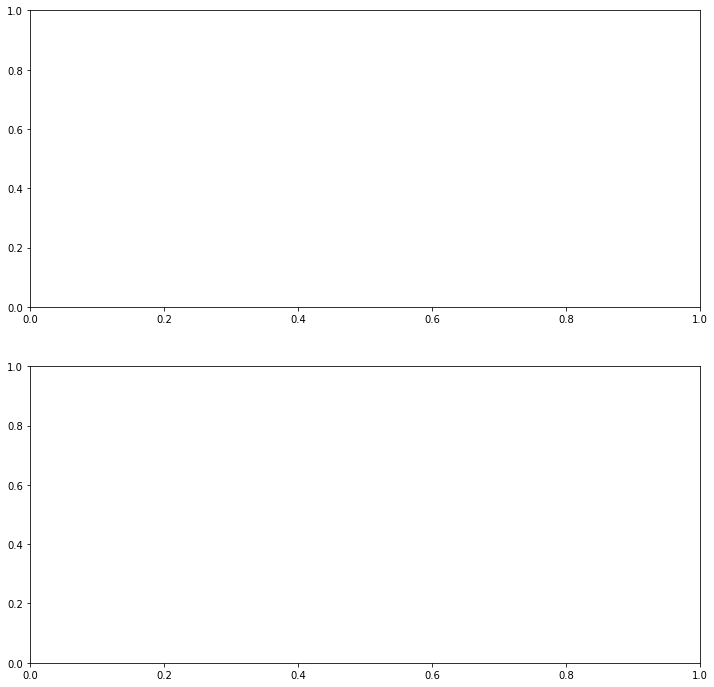

In [63]:
#Plot the loss
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()